# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from category_encoders import TargetEncoder

%matplotlib inline

In [2]:
from os import walk
for (dirpath, dirnames, filenames) in walk("../input"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
    print("File name: ", filenames)

Directory path:  ../input
Folder name:  ['bi-ml-competition-2023']
File name:  []
Directory path:  ../input/bi-ml-competition-2023
Folder name:  []
File name:  ['train_data.csv', 'test_raw_data.jsonl', 'test_data.csv', 'train_raw_data.jsonl', 'train_targets.csv']


In [3]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [4]:
PATH_TO_DATA = "/kaggle/input/bi-ml-competition-2023"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [5]:
df_train_features.shape

(31698, 245)

In [6]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [7]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


In [8]:
# Префиксы колонок игроков
players_id = []
for i in range(1, 6):
    players_id.append("r" + str(i))
    players_id.append("d" + str(i))
players_id

['r1', 'd1', 'r2', 'd2', 'r3', 'd3', 'r4', 'd4', 'r5', 'd5']

In [9]:
# Используем TargetEncoder для шифрования категориальных признаков ["game_mode", "lobby_type", "hero_id"]
# TargetEncoder - способ шифрования категориальных переменных, при котором последние заменяются вероятностью получить определенный таргет при данной категории
# (референс - https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
#
# Данный метод не увеличивает размерность данных и позволяет относительно легко закодировать переменные с множественными градациями.
# Ограничением метода является его склонность к переучиванию - тем не менее, это можно проверить по точности предсказаний на X_valid.
# 

encoder = TargetEncoder()
df_train_features['game_mode'] = df_train_features.game_mode.astype('category')

df_train_features['lobby_type'] = df_train_features.lobby_type.astype('category')

for el in players_id:
    df_train_features[el + '_hero_id'] = df_train_features[el + '_hero_id'].astype('category')
    
df_train_features = encoder.fit_transform(df_train_features,df_train_targets['radiant_win'])

In [10]:
# Encoder содержит информацию о переменных game_mode, lobby_type, hero_id
encoder

TargetEncoder(cols=['game_mode', 'lobby_type', 'r1_hero_id', 'r2_hero_id',
                    'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id',
                    'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'])

In [11]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,0.513034,0.524230,3,10,0.410855,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,0.530063,0.524230,0,0,0.570201,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,0.527997,0.526681,0,0,0.590308,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,0.527997,0.524230,1,0,0.525886,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,0.527997,0.526681,2,2,0.534091,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


## <left>Наша первая модель

In [12]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [14]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

# Увеличим глубину дерева до 10

CPU times: user 50 s, sys: 117 ms, total: 50.1 s
Wall time: 12.9 s


RandomForestClassifier(max_depth=10, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [15]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [16]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)



ROC-AUC score на отложенной части: 0.7963755050109935


Посмотрим на accuracy:

In [17]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

# Как мы видим на test_split, использование TargetEncoder и большая глубина дерева увеличивают accuracy на X_valid.
# Это показатель того, что модель ещё можно обучать. Используем cross-validation как более эффективный метод регуляризации.

Accuracy score (p > 0.5) на отложенной части: 0.7080967402733964


## <left>Посылка

In [18]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

# Используем ту же кодировку категориальных признаков в test датасете, как и для validation датасета.
# ВАЖНО: чтобы избежать переобучения, в случае test датасета мы используем encoder.transform, 
# который игнорирует информацию о зависимой переменной (в отличие от encoder.fit_transform для train, где мы обучаем encoder)

df_test_features['game_mode'] = df_test_features.game_mode.astype('category')

df_test_features['lobby_type'] = df_test_features.lobby_type.astype('category')

for el in players_id:
    df_test_features[el + '_hero_id'] = df_test_features[el + '_hero_id'].astype('category')

df_test_features = encoder.transform(df_test_features)

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [19]:
# submission_filename = "submission_{}.csv".format(
#     datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
# df_submission.to_csv(submission_filename)
# print("Файл посылки сохранен, как: {}".format(submission_filename))

## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [20]:
# CV - метод который чаще всего используют вместе с TargetEncoding. При каждом разбиении данных на train и validation
# новый validation set будет иметь категории, которые не встречаются в train set. 
# Чем больше мы поставим разбиений, тем с большей вероятностью поймаем случаи с разными категориями в train и validation,
# и среднее значение ROC-AUC будет лучше отражать реальную обучаемость нашей модели.

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [21]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 9.8 s, sys: 864 ms, total: 10.7 s
Wall time: 1min 15s


In [22]:
cv_scores_rf

array([0.79637551, 0.79348633, 0.78773831, 0.7916593 , 0.79352819])

In [23]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7925575257877382


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [24]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [25]:
# Проверим категории в исходном json и поле objectives
for key, value in match.items():
    print(key)

match["objectives"]

game_time
match_id_hash
teamfights
objectives
chat
game_mode
lobby_type
players
targets


[{'time': 53.154,
  'type': 'CHAT_MESSAGE_FIRSTBLOOD',
  'slot': 2,
  'key': 7,
  'player_slot': 2},
 {'time': 947.135, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': -1},
 {'time': 1069.106,
  'type': 'CHAT_MESSAGE_TOWER_KILL',
  'team': 2,
  'slot': 0,
  'player_slot': 0},
 {'time': 1116.761, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 3, 'slot': -1},
 {'time': 1153.485, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 3, 'slot': -1},
 {'time': 1282.254,
  'type': 'CHAT_MESSAGE_TOWER_KILL',
  'team': 2,
  'slot': 2,
  'player_slot': 2},
 {'time': 1510.065,
  'type': 'CHAT_MESSAGE_TOWER_DENY',
  'team': 60,
  'slot': 7,
  'player_slot': 130},
 {'time': 1544.323,
  'type': 'CHAT_MESSAGE_TOWER_DENY',
  'team': 60,
  'slot': 4,
  'player_slot': 4},
 {'time': 1719.222,
  'type': 'CHAT_MESSAGE_TOWER_KILL',
  'team': 2,
  'slot': 2,
  'player_slot': 2},
 {'time': 1778.892, 'type': 'CHAT_MESSAGE_ROSHAN_KILL', 'team': 2},
 {'time': 1779.828, 'type': 'CHAT_MESSAGE_AEGIS', 'slot': 2, 'player_sl

In [26]:
player = match["players"][0]
player["kills"], player["deaths"], player["assists"]

(2, 4, 16)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [27]:
player["ability_uses"]

{'lich_dark_ritual': 26,
 'lich_frost_nova': 30,
 'lich_frost_armor': 63,
 'lich_chain_frost': 7}

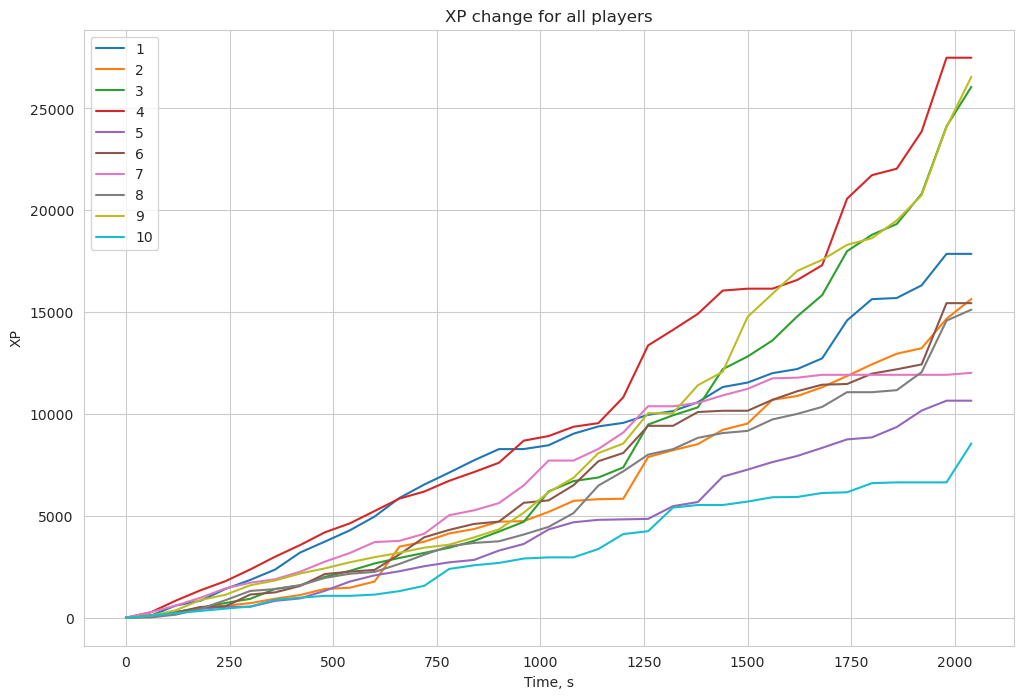

In [28]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [29]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [30]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        radiant_roshan_kills = 0
        dire_roshan_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
            if objective["type"] == "CHAT_MESSAGE_ROSHAN_KILL":
                if objective["team"] == 2:
                    radiant_roshan_kills += 1
                if objective["team"] == 3:
                    dire_roshan_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
        # Считаем количество взятых рошанов обеими командами (дает золото всей команде и артефакт Aegis)
        df_features.loc[match_id_hash, "radiant_roshan_kills"] = radiant_roshan_kills
        df_features.loc[match_id_hash, "dire_roshan_kills"] = dire_roshan_kills
        df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_roshan_kills - dire_roshan_kills
        
        radiant_team_gold = 0
        dire_team_gold = 0
        radiant_team_dmg = 0
        dire_team_dmg = 0
        radiant_team_xp = 0
        dire_team_xp = 0
        
        # Если игроки идут в том же порядке, как и в df_train_features
        for i, player in enumerate(match["players"][:5]):
            
            # KDA игроков команды Radiant
            if player["deaths"] >0 :
                df_features.loc[match_id_hash, "r" + str(i+1) + "_kda"] = (player["kills"] + player["assists"])/player["deaths"]
            else:
                df_features.loc[match_id_hash, "r" + str(i+1) + "_kda"] = (player["kills"] + player["assists"])
                
            radiant_team_gold += player["gold"]
            radiant_team_xp += player["xp"]
            
            # Урон по героям игроков команды Radiant
            df_features.loc[match_id_hash, "r" + str(i+1) + "_hero_dmg"] = sum([value for key, value in player['damage'].items() if 'hero' in key.lower()])
            radiant_team_dmg += sum([value for key, value in player['damage'].items() if 'hero' in key.lower()])
            
            # Изменения в золоте по сравнению с первой половиной матча игроков команды Radiant
            if len(player['gold_t']):
                df_features.loc[match_id_hash, "r" + str(i+1) + "_gold_increase"] = player['gold'] - player['gold_t'][len(player['gold_t'])//2]
            else:
                df_features.loc[match_id_hash, "r" + str(i+1) + "_gold_increase"] = 0
            
        for i, player in enumerate(match["players"][5:]):
            
            #KDA игроков команды Dire
            if player["deaths"] >0 :
                df_features.loc[match_id_hash, "d" + str(i+1) + "_kda"] = (player["kills"] + player["assists"])/player["deaths"]
            else:
                df_features.loc[match_id_hash, "d" + str(i+1) + "_kda"] = (player["kills"] + player["assists"])
                
            dire_team_gold += player["gold"]
            dire_team_xp += player["xp"]
            
            # Урон по героям игроков команды Dire
            df_features.loc[match_id_hash, "d" + str(i+1) + "_hero_dmg"] = sum([value for key, value in player['damage'].items() if 'hero' in key.lower()])
            dire_team_dmg = sum([value for key, value in player['damage'].items() if 'hero' in key.lower()])
            
            # Изменения в золоте по сравнению с первой половиной матча игроков команды Dire
            if len(player['gold_t']):
                df_features.loc[match_id_hash, "d" + str(i+1) + "_gold_increase"] = player['gold'] - player['gold_t'][len(player['gold_t'])//2]
            else:
                df_features.loc[match_id_hash, "d" + str(i+1) + "_gold_increase"] = 0
        
        # Общая разница по золоту между командами
        # Это вторая метрика, связанная с золотом, так как оригинальная статья использует этот признак как универсальный показатель успеха игроков
        df_features.loc[match_id_hash, "radiant_team_gold"] = radiant_team_gold
        df_features.loc[match_id_hash, "dire_team_gold"] = dire_team_gold
        df_features.loc[match_id_hash, "diff_team_gold"] = radiant_team_gold - dire_team_gold
        
        # Общая разница в уроне по персонажам
        df_features.loc[match_id_hash, "radiant_team_dmg"] = radiant_team_dmg
        df_features.loc[match_id_hash, "dire_team_dmg"] = dire_team_dmg
        df_features.loc[match_id_hash, "diff_team_dmg"] = radiant_team_dmg - dire_team_dmg
        
        # Общая разница в полученном опыте
        df_features.loc[match_id_hash, "radiant_team_xp"] = radiant_team_xp
        df_features.loc[match_id_hash, "dire_team_xp"] = dire_team_xp
        df_features.loc[match_id_hash, "diff_team_xp"] = radiant_team_xp - dire_team_xp
        

        
        

In [31]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [32]:
df_train_features_extended.head(10)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_gold_increase,radiant_team_gold,dire_team_gold,diff_team_gold,radiant_team_dmg,dire_team_dmg,diff_team_dmg,radiant_team_xp,dire_team_xp,diff_team_xp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,0.513034,0.524230,3,10,0.410855,7,2,0,7,...,542.0,18172.0,13144.0,5028.0,17463.0,926.0,16537.0,17566.0,12925.0,4641.0
6db558535151ea18ca70a6892197db41,21,0.530063,0.524230,0,0,0.570201,0,0,0,0,...,95.0,880.0,480.0,400.0,70.0,0.0,70.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,0.527997,0.526681,0,0,0.590308,0,0,0,1,...,326.0,2947.0,1843.0,1104.0,2270.0,0.0,2270.0,2942.0,2513.0,429.0
c96d629dc0c39f0c616d1949938a6ba6,1016,0.527997,0.524230,1,0,0.525886,0,3,3,5,...,1903.0,23650.0,20819.0,2831.0,23872.0,1218.0,22654.0,26116.0,27341.0,-1225.0
156c88bff4e9c4668b0f53df3d870f1b,582,0.527997,0.526681,2,2,0.534091,3,1,2,9,...,783.0,12628.0,13418.0,-790.0,9830.0,1888.0,7942.0,13044.0,13598.0,-554.0
df50f738c454d430a33b2bf90cb9ef1a,636,0.527997,0.526681,1,5,0.522463,1,1,0,3,...,2988.0,11422.0,15938.0,-4516.0,9442.0,3569.0,5873.0,11875.0,16068.0,-4193.0
7469e9440ea3d19b211a484647c7126e,1054,0.527997,0.524230,8,5,0.575563,1,3,10,4,...,3759.0,27200.0,27107.0,93.0,23217.0,6136.0,17081.0,26068.0,25212.0,856.0
0aa1c6d7630433a93fe42da5ac810368,1797,0.527997,0.526681,9,2,0.555178,1,5,2,1,...,4345.0,50645.0,55254.0,-4609.0,57051.0,4550.0,52501.0,55732.0,65908.0,-10176.0
892b5d40992e4b334e159f99b2bb55e6,605,0.527997,0.526681,0,5,0.504425,0,1,3,1,...,1756.0,13431.0,12183.0,1248.0,12807.0,1177.0,11630.0,14501.0,14362.0,139.0


In [33]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 157 ms, sys: 223 ms, total: 380 ms
Wall time: 2min 40s


In [34]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7925575257877382
ROC-AUC на кросс-валидации для новых признаков: 0.8190755271592135


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

In [35]:
# Скопируем тестовую таблицу с признаками
df_test_features_extended = df_test_features.copy()

# Добавим новые
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [36]:
# Используем расширенный X; y остаётся таким же
X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [37]:
# Разбиваем X, y на train, valid в отношении 70/30 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [38]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

# Тренируем модель заново на расширенном X_train, чтобы она совпадала по количеству параметров с расширенным X_test

CPU times: user 1min 2s, sys: 107 ms, total: 1min 2s
Wall time: 16.5 s


RandomForestClassifier(max_depth=10, n_estimators=300, n_jobs=-1,
                       random_state=10801)

In [39]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [40]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

# Ожидаем похожий результат на test выборке

ROC-AUC score на отложенной части: 0.8185111032345894


In [41]:
# Используем расширенный X_test
X_test = df_test_features_extended.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features_extended.index)

In [42]:
# Насколько я поняла, для финальной посылки нужен "submission.csv"
submission_filename = "submission.csv"
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission.csv
